# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: destination path 'ipcv-assignment-2' already exists and is not an empty directory.


In [2]:
import warnings
warnings.filterwarnings('ignore')
!pip install torchinfo

In [3]:
import torch
from torch import nn, Tensor
import torch.optim as optim
import numpy as np
import random
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import decode_image
from torchinfo import summary
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from PIL import Image
from datetime import datetime
from typing import Optional
from torchvision.models import resnet18, ResNet18_Weights

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

SAVE_DIR = "./"
NUM_WORKERS = 2

Using cuda device


In [5]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Since the dataset is small enough to fit comfortably in memory and the disk I/O represented the biggest bottleneck during training, we choose to trade memory for speed by caching all images in device memory. This trick grants a faster training

In [6]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [7]:
# Defining custom Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_convs:int, growth_rate:int, has_transition:bool = True):
        super(DenseBlock, self).__init__()
        self.num_convs = num_convs
        self.growth_rate = growth_rate
        layer = []
        for i in range(num_convs):
            layer.append(self.conv_block(growth_rate))
        self.dense_net = nn.Sequential(*layer)
        self.transition_net = self.transition_block() if has_transition else None

    def conv_block(self, num_channels):
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_channels, 3, padding=1))
        )

    # Transition block to reduce channel dimensionality (conv has to be 1x1)
    def transition_block(self):
        compression_factor = 0.5
        num_transition_channels = int(compression_factor * (self.growth_rate * self.num_convs))
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_transition_channels, 1),
                nn.AvgPool2d(2, stride=2)
                )
        )

    def forward(self, X):
        # In the Dense block, every layer has in input the concatenation of all the previous ones
        for block in self.dense_net:
            last_out = block(X)
            X = torch.cat((X, last_out), dim=1)
        if self.transition_net != None:
            X = self.transition_net(X)
        return X

In [8]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, num_dense_blocks, num_conv_each_dense, growth_rate, dropout):
        super().__init__()
        stem_block = [ #initial stem block, like resnet
            nn.LazyConv2d(32, 7, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
        ]

        dense_core = [
            DenseBlock(num_convs=num_conv_each_dense[i], growth_rate=growth_rate, has_transition= True ) for i in range(num_dense_blocks)
        ]

        classification_block = [
            nn.LazyBatchNorm2d(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.LazyLinear(37)
        ]

        self.net_stack = nn.Sequential(*stem_block, *dense_core, *classification_block)

    def forward(self, x):
        result = self.net_stack(x)
        return result

In [9]:
def model_size(model: nn.Module) -> float:
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_mb = round(size_all_mb, 2)
    return size_all_mb

In [10]:
def train(dataloader, model, loss_fn, optimizer, scheduler, lr_data):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device) # Move data to the same device as the model
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        num_batches += 1
        lr_data.append(optimizer.param_groups[0]["lr"])

    avg_loss = total_loss / num_batches
    return avg_loss

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # Move data to the same device as the model
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

In [12]:
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # --- Accuracy ---
    accuracy = correct / total

    # --- Confusion Matrix ---
    num_classes = outputs.shape[1]
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(all_labels, all_preds):
        conf_matrix[t, p] += 1

    # --- Precision, Recall, F1 ---
    tp = conf_matrix.diag()
    fp = conf_matrix.sum(dim=0) - tp
    fn = conf_matrix.sum(dim=1) - tp

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    # Weighted (by class support)
    support = conf_matrix.sum(dim=1)
    weighted_precision = (precision * support).sum() / support.sum()
    weighted_recall = (recall * support).sum() / support.sum()
    weighted_f1 = (f1 * support).sum() / support.sum()

    return {
        "test_accuracy": accuracy,
        "test_precision": weighted_precision.item(),
        "test_recall": weighted_recall.item(),
        "test_f1": weighted_f1.item()
    }

In [13]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Declaration of data augumentation stacks
training_data_augumentation_stacks = {
    "default" : transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5,
            hue=0.1
        ),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN,
                    std=STD),
    ]),

    "same_as_default_but_lighter" : transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.05
        ),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN,
                    std=STD),
    ])
}

In [14]:
def run_experiment(parameters, resnet_model=None):
    print("="*60 + f"\nStart running the model: {parameters.get('experiment_name')}\n" + "="*60)
    BATCH_SIZE = parameters.get("batch_size", 64)
    N_DENS_BLKS = parameters.get("n_dense_blocks", 3)
    N_CONVS_EACH_BLCK = parameters.get("n_conv_each_block", [4,8,7])
    GRWTH_RATE = parameters.get("growth_rate", 12)
    DROPOUT = parameters.get("dropout", 0.1)
    BASE_LR = parameters.get("base_learning_rate", 0.001)
    WARMUP_ITERS = parameters.get("warmup_iter", 7500)
    MAIN_SCH_KICK = parameters.get("main_sched_epochs_kick_in", 60)
    EPOCHS = parameters.get("n_epochs", 100)
    WEIGHT_DECAY = parameters.get("weight_decay", 0.001)
    TRAINING_TRANSFORM_STACK = training_data_augumentation_stacks[parameters.get("transform_stack_name", "default")]
    EXPERIMENT_TYPE = parameters.get("experiment_name", "default") # Use experiment_name for consistency

    # Dataset definition
    validation_transform_stack = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # Added ToTensor here
        transforms.Normalize(MEAN, STD)
    ])

    train_dataset = OxfordPetDataset(split="train" , transform=TRAINING_TRANSFORM_STACK)
    validation_dataset = OxfordPetDataset(split="val", transform=validation_transform_stack)
    test_dataset = OxfordPetDataset(split="test", transform=validation_transform_stack)

    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # Create model
    if resnet_model is not None:
        model = resnet_model.to(device)
    else:
        model = NeuralNetwork(num_dense_blocks=N_DENS_BLKS, num_conv_each_dense=N_CONVS_EACH_BLCK, growth_rate=GRWTH_RATE, dropout=DROPOUT).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

    warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1., total_iters=WARMUP_ITERS)
    main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.01, patience=8)

    batch_lrs = []           # record learning rate per batch
    epoch_end_indices = []   # store index (batch count) at the end of each epoch
    net_performance_data = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }
    t1 = time.time()
    best_val_accuracy = 0.0
    best_model_state = None

    # Add tqdm progress bar
    experiment_name = parameters.get("experiment_name", EXPERIMENT_TYPE)
    pbar = tqdm(range(EPOCHS), desc=f"Training {experiment_name}")

    for t in pbar:
        train_loss = train(train_dataloader, model, loss_fn, optimizer, warmup_scheduler, batch_lrs)
        val_accuracy, val_loss = test(validation_dataloader, model, loss_fn)
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            if resnet_model is not None: # Only save for the ResNet model in part 2, custom model not needed to be saved for part 1
                print("TEST")
                torch.save(best_model_state, Path(SAVE_DIR) / f"{experiment_name}.pt")
        if t > MAIN_SCH_KICK:
            main_scheduler.step(val_accuracy)

        net_performance_data["train_loss"].append(train_loss)
        net_performance_data["val_loss"].append(val_loss)
        net_performance_data["val_accuracy"].append(val_accuracy)
        epoch_end_indices.append(len(batch_lrs))

        # Update progress bar with metrics
        pbar.set_postfix({
            "Train Loss": f"{train_loss:.4f}",
            "Val Loss": f"{val_loss:.4f}",
            "Val Acc": f"{val_accuracy:.4f}"
        })

        # Compute size on first epoch (after lazy layers are initialized)
        if t == 0:
            model_size_value = model_size(model)
            net_performance_data["model_size_mb"] = model_size_value

    t2 = time.time()
    elapsed_time = t2-t1

    print("Done in ", elapsed_time, " sec")
    print("Best accuracy ", np.max(net_performance_data["val_accuracy"]))

    net_performance_data_df = pd.DataFrame(data=net_performance_data)
    # add all experiment parameters to the result dataframe
    for key in parameters:
        if isinstance(parameters[key], list):
            for i, el in enumerate(parameters[key]):
                net_performance_data_df[key + "_"+ str(i)] = el
        else:
            net_performance_data_df[key] = parameters[key]

    # add elapsed time
    net_performance_data_df["elapsed_time_sec"] = elapsed_time

    # create a column for epochs steps indexes
    net_performance_data_df = net_performance_data_df.reset_index().rename(columns={"index":"epoch"})

    # add final evaluation stats
    eval_performaces = evaluate_model(test_dataloader, model)
    for metric in eval_performaces:
        net_performance_data_df[metric] = eval_performaces[metric]

    return net_performance_data_df

### Ablation study

In [15]:
parameters_base = [
    # Baseline
    {
        "experiment_name": "24_grwth_rate_baseline",
        "batch_size" : 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },

    # Experiments on regularization
    {
        "experiment_name": "high_dropout",
        "batch_size" : 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.4,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "weight_decay_heavy",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.007,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "near_zero_weight_decay",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.00005,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "light_data_aug",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "same_as_default_but_lighter"
    },

    # Experiments on model size
    {
        "experiment_name": "capacity_increase_blocks_growth",
        "batch_size": 64,
        "n_dense_blocks": 4,
        "n_conv_each_block": [6, 12, 16, 14],
        "growth_rate": 32,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "lightweight_model_ablation",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [4, 10, 10],
        "growth_rate": 16,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 5000,
        "main_sched_epochs_kick_in": 60,
        "n_epochs": 180,
        "weight_decay": 0.0005,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "deep_dense_blocks",
        "batch_size": 32,
        "n_dense_blocks": 3,
        "n_conv_each_block": [12, 24, 24],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.0008,
        "warmup_iter": 10000,
        "main_sched_epochs_kick_in": 90,
        "n_epochs": 180,
        "weight_decay": 0.0015,
        "transform_stack_name": "default"
    },

    # Experiments on training parameters
    {
        "experiment_name": "large_warmup",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.0005,
        "warmup_iter": 20000,
        "main_sched_epochs_kick_in": 90,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "batch32_lr_double",
        "batch_size": 32,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.002,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "big_128batch",
        "batch_size": 128,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    }
]

In [16]:
total_results = []
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

### Actual run of the experiments
# Check if results.csv exists locally or in SAVE_DIR
local_results_path = Path("./results.csv")
drive_results_path = Path(SAVE_DIR) / "results.csv"

if not local_results_path.exists() and not drive_results_path.exists():
    for par in parameters_base:
        total_results.append(run_experiment(par))
        # update partial results after each experiment
        df_combined = pd.concat(total_results, ignore_index=True)
        df_combined.to_csv(drive_results_path) # Save to Drive
elif local_results_path.exists():
    print(f"Loading results from local: {local_results_path}")
    total_results_df = pd.read_csv(local_results_path)
    total_results = [total_results_df]
elif drive_results_path.exists():
    print(f"Loading results from Google Drive: {drive_results_path}")
    total_results_df = pd.read_csv(drive_results_path)
    total_results = [total_results_df]


Loading results from local: results.csv


In [17]:
drive_results_path = Path(SAVE_DIR) / "results.csv"
custom_net_df = pd.read_csv(drive_results_path)
sns.set_theme(style="whitegrid", context="talk")

# ================================================================
# 1. TRAIN/VAL LOSS CURVES BY EXPERIMENT
# ================================================================
def plot_loss_curves(df):
    experiment_names = df["experiment_name"].unique()
    n_experiments = len(experiment_names)

    # Calculate grid dimensions (roughly square)
    n_cols = int(np.ceil(np.sqrt(n_experiments)))
    n_rows = int(np.ceil(n_experiments / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

    # Flatten axes array for easy iteration
    if n_experiments == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, name in enumerate(experiment_names):
        sub = df[df["experiment_name"] == name]
        ax = axes[idx]

        ax.plot(sub["epoch"], sub["train_loss"], alpha=0.7, label="Train Loss", color='indigo')
        ax.plot(sub["epoch"], sub["val_loss"], alpha=0.7, linestyle="--", label="Val Loss", color='darksalmon')

        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"{name}", fontsize=10, wrap=True)
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(n_experiments, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# ================================================================
# 2. BEST TEST ACCURACY PER EXPERIMENT — BARPLOT
# ================================================================
def plot_test_accuracy(df):
    df_best = df.groupby("experiment_name").agg({"test_accuracy": "max"}).reset_index()
    df_best = df_best.sort_values("test_accuracy", ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(data=df_best, x="test_accuracy", y="experiment_name", palette="magma")
    plt.xlabel("Test Accuracy")
    plt.ylabel("Experiment")
    plt.title("Test Accuracy by Experiment")
    plt.tight_layout()
    plt.show()

# ================================================================
# 3. EFFECT OF SINGLE HYPERPARAMETERS ON TEST ACCURACY
# ================================================================
def plot_hyperparam_performance(df, hyperparam):
    plt.figure(figsize=(8, 5))

    # Group by hyperparameter value and calculate mean + std
    grouped = df.groupby(hyperparam)['test_accuracy'].agg(['mean', 'std', 'count']).reset_index()

    # Create bar plot with error bars
    plt.bar(grouped[hyperparam].astype(str), grouped['mean'],
            yerr=grouped['std'], capsize=5, alpha=0.7, edgecolor='black', color='darksalmon')

    # Add value labels on top of bars
    for i, row in grouped.iterrows():
        plt.text(i, row['mean'] + row['std'] + 0.001,
                f"{row['mean']:.3f}", ha='center', fontweight='bold')

    plt.xlabel(hyperparam, fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title(f'Effect of {hyperparam} on Test Accuracy', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ================================================================
# 4. REGULARIZATION TECHNIQUES COMPARISON
# ================================================================
def compare_regularization(df):
    plt.figure(figsize=(12, 6))

    reg_experiments = {
        "24_grwth_rate_baseline": "Baseline",
        "high_dropout": "High Dropout",
        "weight_decay_heavy": "Heavy Weight Decay",
        "near_zero_weight_decay": "Minimal Weight Decay",
        "light_data_aug": "Light Data Augmentation"
    }

    df_reg = df[df['experiment_name'].isin(reg_experiments.keys())]

    for name, label in reg_experiments.items():
        sub = df_reg[df_reg['experiment_name'] == name]
        # Just take the mean across all runs per epoch
        grouped = sub.groupby('epoch')['val_accuracy'].mean()
        plt.plot(grouped.index, grouped.values, label=label, linewidth=3, alpha=0.8)

    plt.xlabel('Epoch', fontsize=13, fontweight='bold')
    plt.ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
    plt.title('Regularization Strategy Comparison', fontsize=15, fontweight='bold')
    plt.legend(fontsize=11, loc='lower right', framealpha=0.95)
    plt.grid(alpha=0.3, linestyle='--')
    plt.xlim(0, 180)
    plt.ylim(0, 75)
    plt.tight_layout()
    plt.show()

# ================================================================
# 5. CORRELATION HEATMAP (Hyperparams vs. Results)
# ================================================================
def plot_correlation_heatmap(df):
    # Keep numeric columns only
    num_df = df.select_dtypes(include=["float64", "int64"]).drop(columns=["epoch"])
    corr = num_df.corr()

    plt.figure(figsize=(14,10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title("Correlation Heatmap of Hyperparameters and Outcomes")
    plt.show()

# ================================================================
# 6. ABLATION: E.g., "Dropout vs Epoch Curve"
# ================================================================
def compare_by_feature(df, feature, metric="val_accuracy"):
    plt.figure(figsize=(10, 5))

    for value, sub in df.groupby(feature):
        # Aggregate across multiple runs if present
        grouped = sub.groupby("epoch")[metric].agg(['mean', 'std']).reset_index()

        # Plot mean with confidence band
        plt.plot(grouped["epoch"], grouped["mean"], label=f"{feature}={value}", linewidth=2)
        plt.fill_between(grouped["epoch"],
                        grouped["mean"] - grouped["std"],
                        grouped["mean"] + grouped["std"],
                        alpha=0.2)

    plt.title(f"{metric} curves grouped by {feature}", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ================================================================
# 7. TEST ACCURACY vs TRAINING TIME (Efficiency Frontier)
# ================================================================
def plot_efficiency(df):
    summary = df.groupby("experiment_name").agg({
        "elapsed_time_sec": "max",
        "test_accuracy": "max",
    }).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=summary,
        x="elapsed_time_sec", y="test_accuracy", hue="test_accuracy",
        palette="viridis", s=150
    )
    plt.xlabel("Training Time (sec)")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs Training Efficiency (Pareto-like View)")
    plt.tight_layout()
    plt.show()

# ================================================================
# 8. TEST ACCURACY VS MODEL SIZE (MB trainable parameters)
# ================================================================
def plot_size_vs_accuracy(df):
    summary = df.groupby("experiment_name").agg({
        "model_size_mb": "max",
        "test_accuracy": "max",
    }).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=summary,
        x="model_size_mb", y="test_accuracy", hue="test_accuracy",
        palette="viridis", s=150
    )
    plt.xlabel("Model Size (MB)")
    plt.ylabel("Test Accuracy")
    plt.title("Model Size vs Test Accuracy")
    plt.tight_layout()
    plt.show()

# ================================================================
# 9. MULTI-PARAMETER GRID PLOT (e.g., dropout × growth_rate)
# ================================================================
def grid_compare(df, x="dropout", y="growth_rate", metric="test_accuracy"):
    summary = df.groupby("experiment_name").mean(numeric_only=True)
    summary = summary.reset_index()

    pivot = summary.pivot_table(values=metric, index=y, columns=x)

    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, cmap="flare")
    plt.title(f"{metric} across {x} × {y} ablation grid")
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()

# ================================================================
# EXTRA: TRAINING TIME COMPARISON ACROSS EXPERIMENTS
# ================================================================
def plot_training_time(df):
    summary = df.groupby("experiment_name")["elapsed_time_sec"].max(numeric_only=True).reset_index()
    summary = summary.sort_values("elapsed_time_sec")

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=summary,
        x="elapsed_time_sec",
        y="experiment_name",
        palette="magma"
    )
    plt.xlabel("Total Training Time (sec)")
    plt.ylabel("Experiment")
    plt.title("Training Time Comparison Across Experiments")
    plt.tight_layout()
    plt.show()

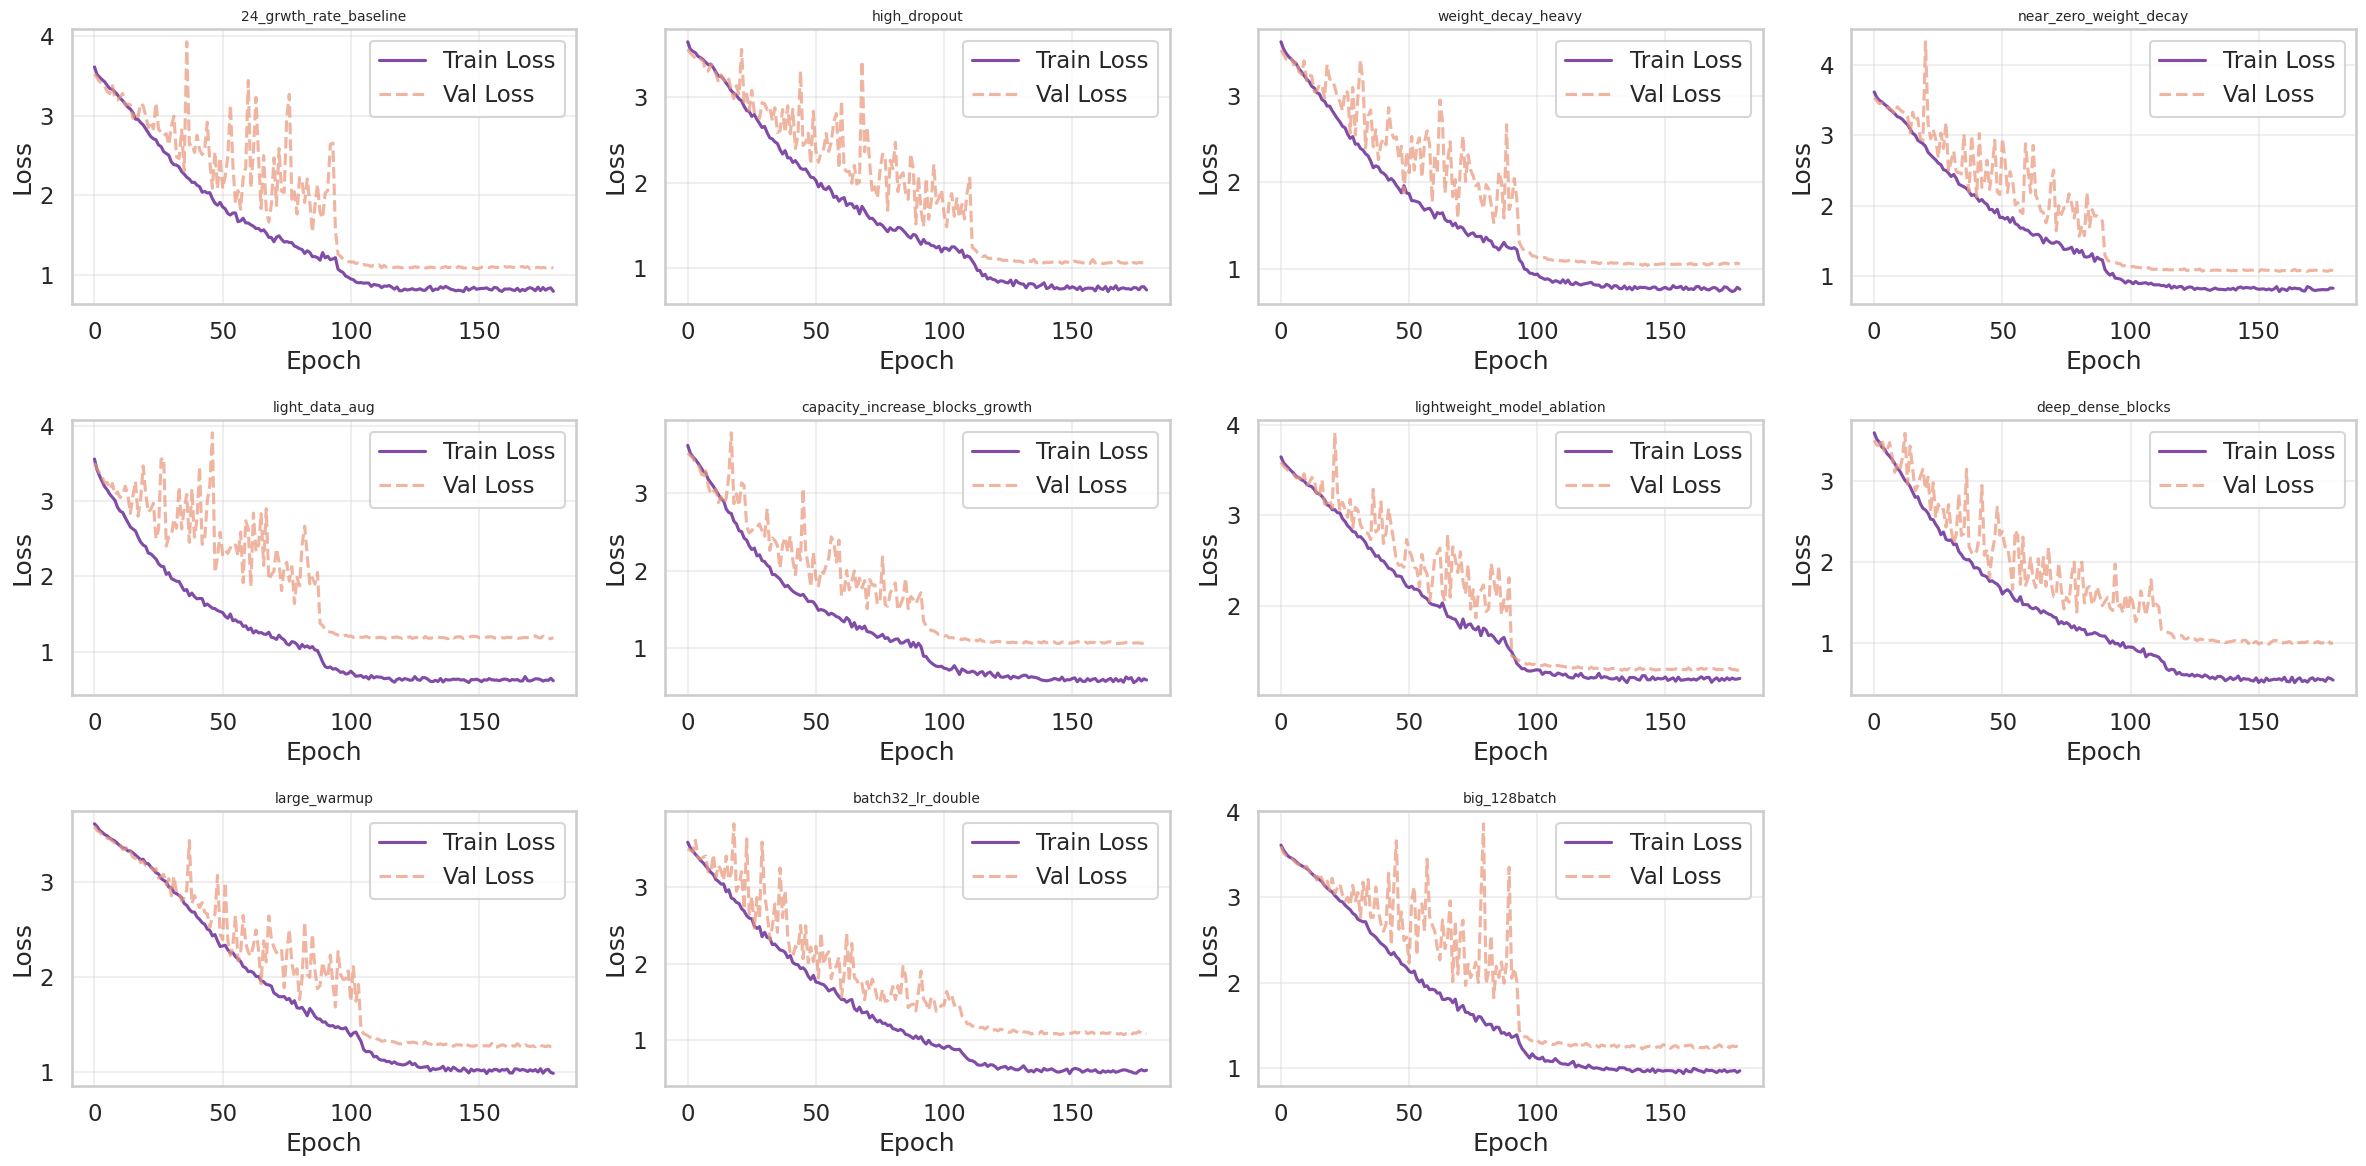

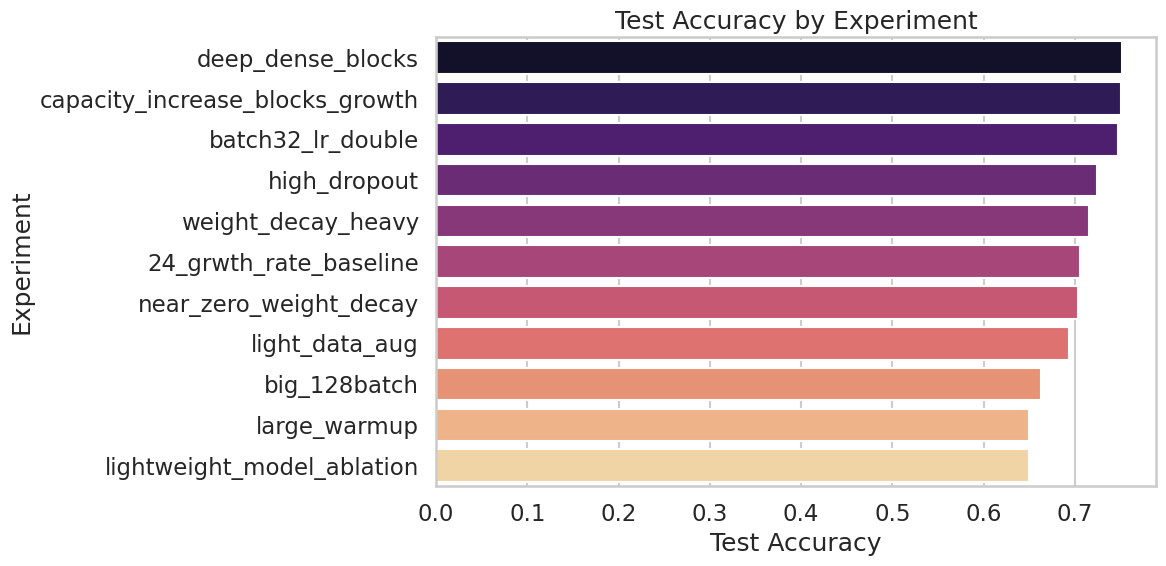

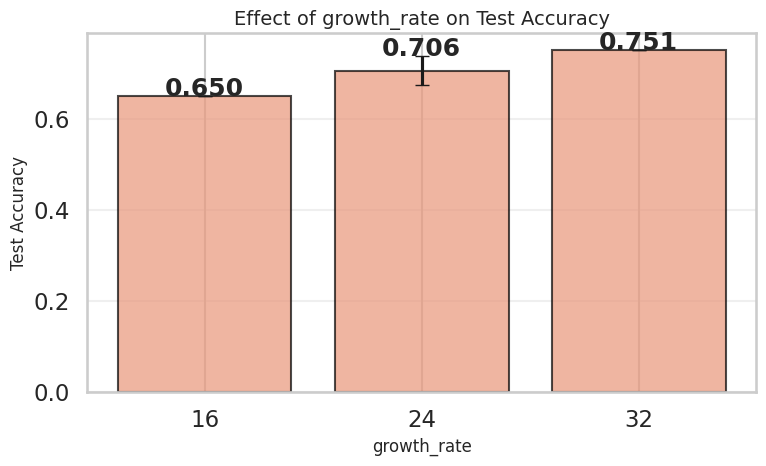

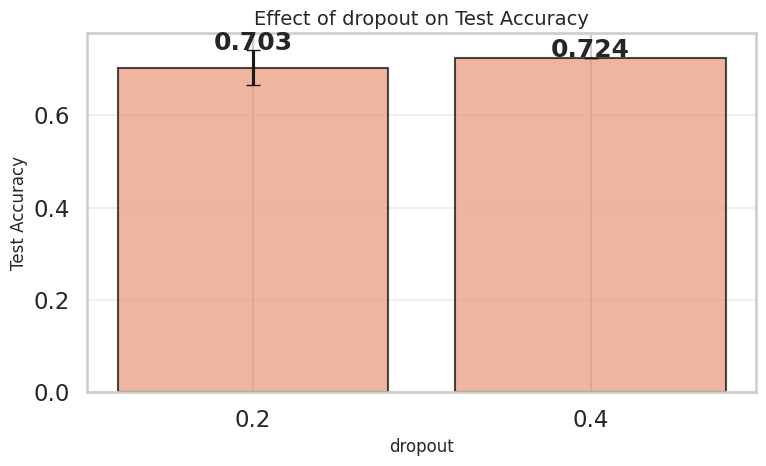

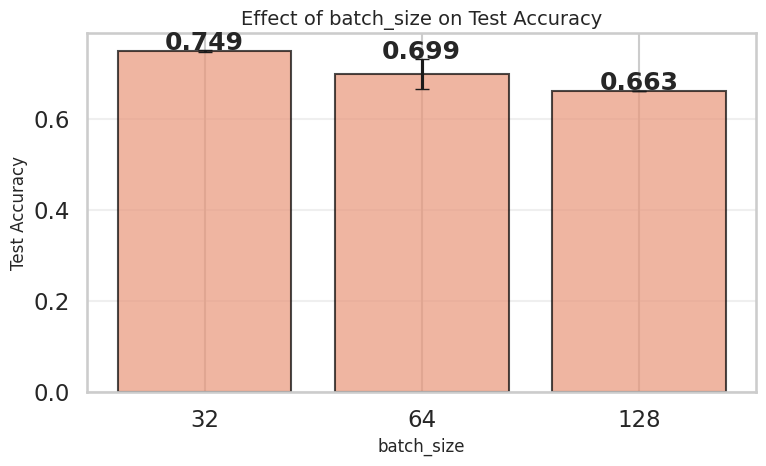

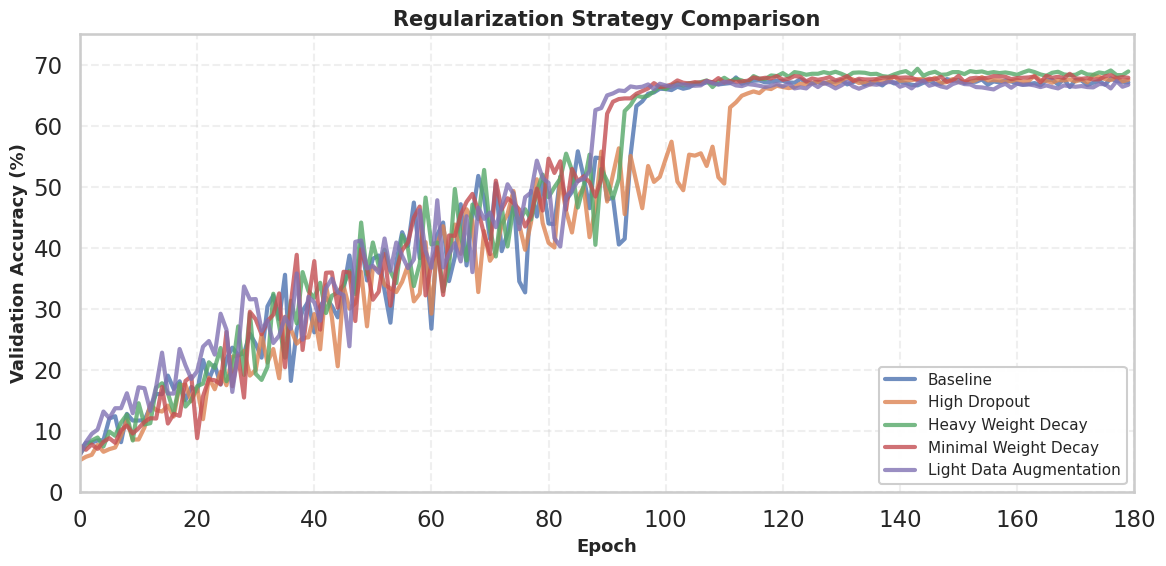

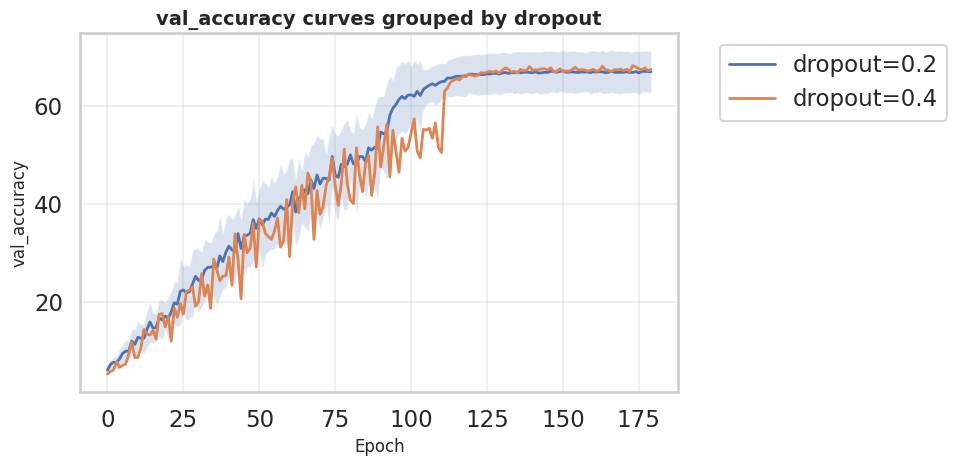

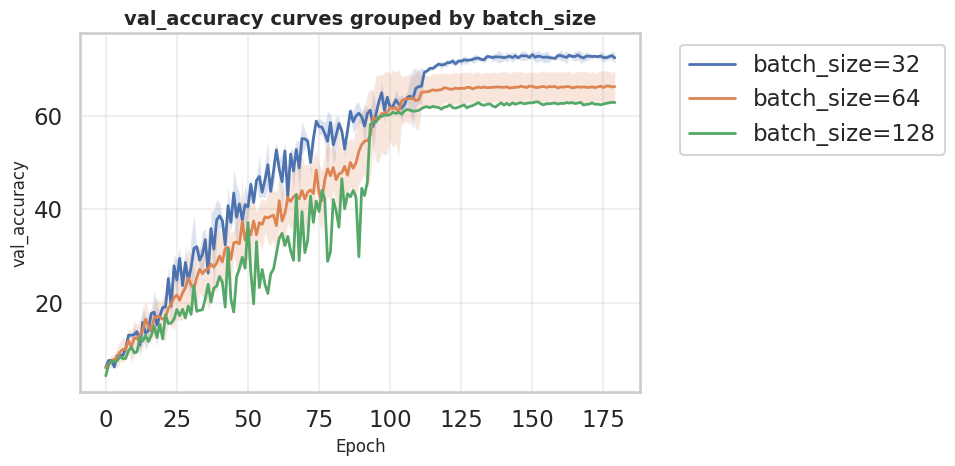

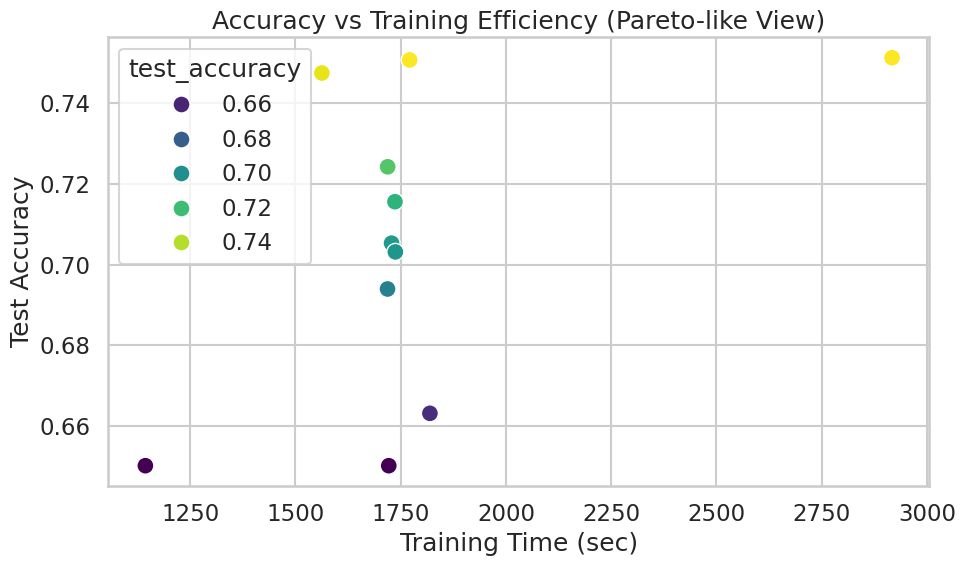

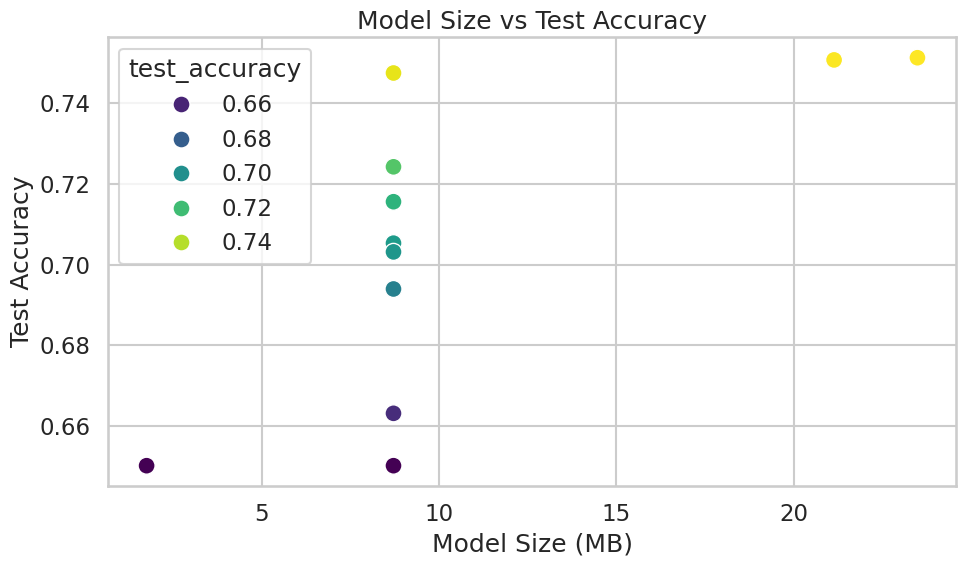

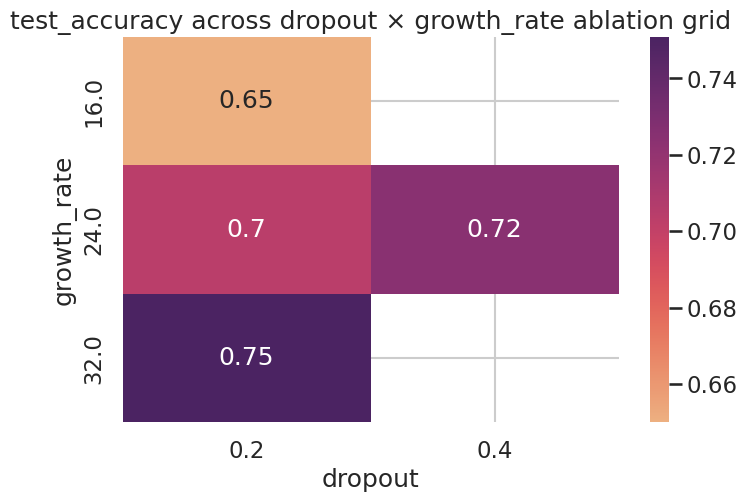

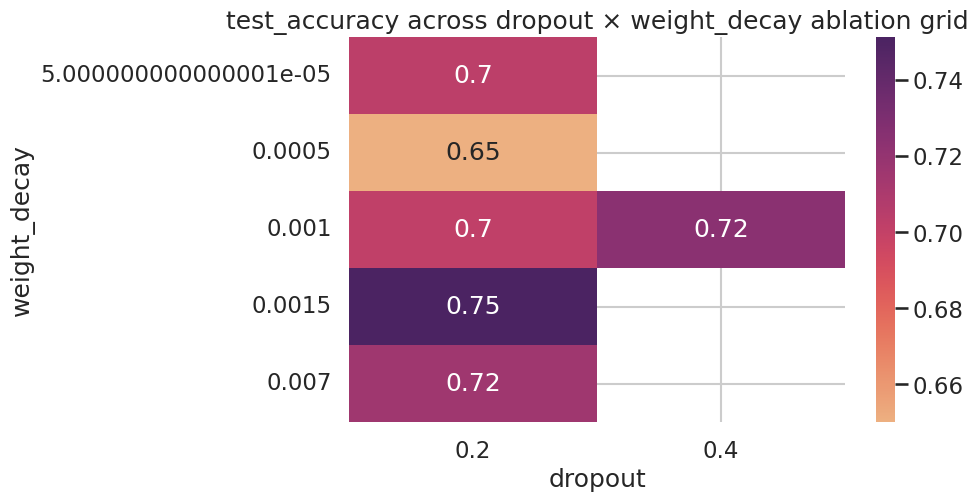

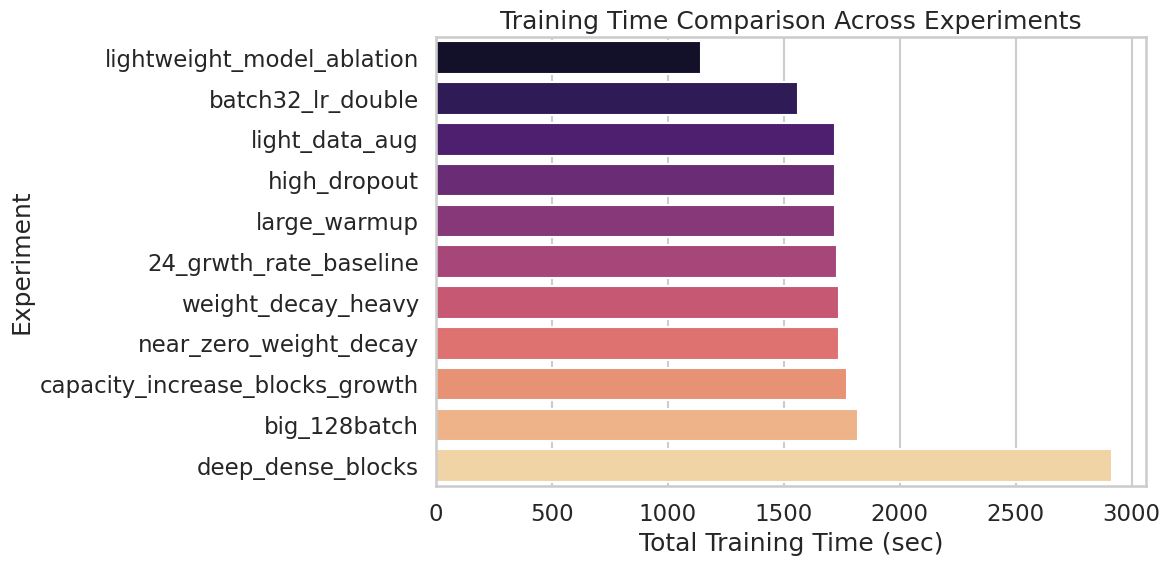

In [18]:
plot_loss_curves(custom_net_df)
plot_test_accuracy(custom_net_df)
plot_hyperparam_performance(custom_net_df, "growth_rate")
plot_hyperparam_performance(custom_net_df, "dropout")
plot_hyperparam_performance(custom_net_df, "batch_size")
compare_regularization(custom_net_df)
# plot_correlation_heatmap(custom_net_df)
compare_by_feature(custom_net_df, "dropout")
compare_by_feature(custom_net_df, "batch_size")
plot_efficiency(custom_net_df)
plot_size_vs_accuracy(custom_net_df)
grid_compare(custom_net_df, x="dropout", y="growth_rate")
grid_compare(custom_net_df, x="dropout", y="weight_decay")
plot_training_time(custom_net_df)


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

### 2A.
 First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.


In [19]:
from torchvision.models import resnet18, ResNet18_Weights

In [20]:
NUM_CLASSES = 37

In [21]:
def get_model(
        num_classes: int,
        weights: Optional[ResNet18_Weights] = None,
        dropout_rate: float = 0.2
    ) -> nn.Module:
    """Gets an image classifier based on ResNet-18.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.

    Returns:
        The required network.
    """
    model = resnet18(weights=weights)
    model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(model.fc.in_features, num_classes)
        )
    return model

In [22]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [23]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(NUM_CLASSES, weights).to(device)

# Freeze early layers of the network
frozen_layers = [
    net_transfer.conv1,
    net_transfer.bn1,
    net_transfer.layer1,
    net_transfer.layer2,
    net_transfer.layer3,
    net_transfer.layer4,
]

for layer in frozen_layers:
    set_requires_grad(layer, False)

summary(
    net_transfer,
    input_size=(1, 3, 224, 224)
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]   

Start running the model: resnet_transfer


Training resnet_transfer:   0%|          | 0/30 [00:00<?, ?it/s]

Training resnet_transfer:   0%|          | 0/30 [00:19<?, ?it/s, Train Loss=3.8883, Val Loss=3.7757, Val Acc=2.8353]

Training resnet_transfer:   3%|▎         | 1/30 [00:19<09:13, 19.10s/it, Train Loss=3.8883, Val Loss=3.7757, Val Acc=2.8353]

TEST


Training resnet_transfer:   3%|▎         | 1/30 [00:38<09:13, 19.10s/it, Train Loss=3.7798, Val Loss=3.6388, Val Acc=3.9804]

Training resnet_transfer:   7%|▋         | 2/30 [00:38<09:07, 19.56s/it, Train Loss=3.7798, Val Loss=3.6388, Val Acc=3.9804]

TEST


Training resnet_transfer:   7%|▋         | 2/30 [00:58<09:07, 19.56s/it, Train Loss=3.6626, Val Loss=3.4971, Val Acc=6.3795]

Training resnet_transfer:  10%|█         | 3/30 [00:58<08:52, 19.71s/it, Train Loss=3.6626, Val Loss=3.4971, Val Acc=6.3795]

TEST


Training resnet_transfer:  10%|█         | 3/30 [01:17<08:52, 19.71s/it, Train Loss=3.5448, Val Loss=3.3603, Val Acc=9.8146]

Training resnet_transfer:  13%|█▎        | 4/30 [01:17<08:17, 19.14s/it, Train Loss=3.5448, Val Loss=3.3603, Val Acc=9.8146]

TEST


Training resnet_transfer:  13%|█▎        | 4/30 [01:35<08:17, 19.14s/it, Train Loss=3.4284, Val Loss=3.2121, Val Acc=15.5398]

Training resnet_transfer:  17%|█▋        | 5/30 [01:35<07:50, 18.84s/it, Train Loss=3.4284, Val Loss=3.2121, Val Acc=15.5398]

TEST


Training resnet_transfer:  17%|█▋        | 5/30 [01:53<07:50, 18.84s/it, Train Loss=3.2917, Val Loss=3.0433, Val Acc=23.3915]

Training resnet_transfer:  20%|██        | 6/30 [01:53<07:28, 18.68s/it, Train Loss=3.2917, Val Loss=3.0433, Val Acc=23.3915]

TEST


Training resnet_transfer:  20%|██        | 6/30 [02:12<07:28, 18.68s/it, Train Loss=3.1802, Val Loss=2.8713, Val Acc=33.8604]

Training resnet_transfer:  23%|██▎       | 7/30 [02:12<07:08, 18.64s/it, Train Loss=3.1802, Val Loss=2.8713, Val Acc=33.8604]

TEST


Training resnet_transfer:  23%|██▎       | 7/30 [02:30<07:08, 18.64s/it, Train Loss=3.0235, Val Loss=2.6950, Val Acc=43.0752]

Training resnet_transfer:  27%|██▋       | 8/30 [02:30<06:48, 18.58s/it, Train Loss=3.0235, Val Loss=2.6950, Val Acc=43.0752]

TEST


Training resnet_transfer:  27%|██▋       | 8/30 [02:49<06:48, 18.58s/it, Train Loss=2.8833, Val Loss=2.5012, Val Acc=49.6183]

Training resnet_transfer:  30%|███       | 9/30 [02:49<06:30, 18.58s/it, Train Loss=2.8833, Val Loss=2.5012, Val Acc=49.6183]

TEST


Training resnet_transfer:  30%|███       | 9/30 [03:07<06:30, 18.58s/it, Train Loss=2.7381, Val Loss=2.3087, Val Acc=56.6521]

Training resnet_transfer:  33%|███▎      | 10/30 [03:07<06:11, 18.56s/it, Train Loss=2.7381, Val Loss=2.3087, Val Acc=56.6521]

TEST


Training resnet_transfer:  33%|███▎      | 10/30 [03:26<06:11, 18.56s/it, Train Loss=2.5802, Val Loss=2.1263, Val Acc=62.8135]

Training resnet_transfer:  37%|███▋      | 11/30 [03:26<05:52, 18.53s/it, Train Loss=2.5802, Val Loss=2.1263, Val Acc=62.8135]

TEST


Training resnet_transfer:  37%|███▋      | 11/30 [03:44<05:52, 18.53s/it, Train Loss=2.4407, Val Loss=1.9490, Val Acc=66.5213]

Training resnet_transfer:  40%|████      | 12/30 [03:44<05:32, 18.49s/it, Train Loss=2.4407, Val Loss=1.9490, Val Acc=66.5213]

TEST


Training resnet_transfer:  40%|████      | 12/30 [04:03<05:32, 18.49s/it, Train Loss=2.2780, Val Loss=1.7770, Val Acc=69.1385]

Training resnet_transfer:  43%|████▎     | 13/30 [04:03<05:13, 18.46s/it, Train Loss=2.2780, Val Loss=1.7770, Val Acc=69.1385]

TEST


Training resnet_transfer:  43%|████▎     | 13/30 [04:21<05:13, 18.46s/it, Train Loss=2.1549, Val Loss=1.6325, Val Acc=71.9738]

Training resnet_transfer:  47%|████▋     | 14/30 [04:21<04:55, 18.45s/it, Train Loss=2.1549, Val Loss=1.6325, Val Acc=71.9738]

TEST


Training resnet_transfer:  47%|████▋     | 14/30 [04:40<04:55, 18.45s/it, Train Loss=2.0471, Val Loss=1.5075, Val Acc=74.0458]

Training resnet_transfer:  50%|█████     | 15/30 [04:40<04:36, 18.46s/it, Train Loss=2.0471, Val Loss=1.5075, Val Acc=74.0458]

TEST


Training resnet_transfer:  50%|█████     | 15/30 [04:58<04:36, 18.46s/it, Train Loss=1.9271, Val Loss=1.3895, Val Acc=76.9357]

Training resnet_transfer:  53%|█████▎    | 16/30 [04:58<04:18, 18.46s/it, Train Loss=1.9271, Val Loss=1.3895, Val Acc=76.9357]

TEST


Training resnet_transfer:  53%|█████▎    | 16/30 [05:17<04:18, 18.46s/it, Train Loss=1.8293, Val Loss=1.2789, Val Acc=78.5714]

Training resnet_transfer:  57%|█████▋    | 17/30 [05:17<04:01, 18.55s/it, Train Loss=1.8293, Val Loss=1.2789, Val Acc=78.5714]

TEST


Training resnet_transfer:  57%|█████▋    | 17/30 [05:36<04:01, 18.55s/it, Train Loss=1.7548, Val Loss=1.1818, Val Acc=81.2977]

Training resnet_transfer:  60%|██████    | 18/30 [05:36<03:44, 18.70s/it, Train Loss=1.7548, Val Loss=1.1818, Val Acc=81.2977]

TEST


Training resnet_transfer:  60%|██████    | 18/30 [05:56<03:44, 18.70s/it, Train Loss=1.6395, Val Loss=1.0988, Val Acc=82.1701]

Training resnet_transfer:  63%|██████▎   | 19/30 [05:56<03:30, 19.11s/it, Train Loss=1.6395, Val Loss=1.0988, Val Acc=82.1701]

TEST


Training resnet_transfer:  63%|██████▎   | 19/30 [06:15<03:30, 19.11s/it, Train Loss=1.5676, Val Loss=1.0355, Val Acc=82.1701]

Training resnet_transfer:  67%|██████▋   | 20/30 [06:15<03:11, 19.19s/it, Train Loss=1.5676, Val Loss=1.0355, Val Acc=82.1701]

Training resnet_transfer:  67%|██████▋   | 20/30 [06:34<03:11, 19.19s/it, Train Loss=1.5246, Val Loss=0.9668, Val Acc=83.0971]

Training resnet_transfer:  70%|███████   | 21/30 [06:34<02:52, 19.18s/it, Train Loss=1.5246, Val Loss=0.9668, Val Acc=83.0971]

TEST


Training resnet_transfer:  70%|███████   | 21/30 [06:53<02:52, 19.18s/it, Train Loss=1.4624, Val Loss=0.8962, Val Acc=83.0425]

Training resnet_transfer:  73%|███████▎  | 22/30 [06:53<02:31, 18.94s/it, Train Loss=1.4624, Val Loss=0.8962, Val Acc=83.0425]

Training resnet_transfer:  73%|███████▎  | 22/30 [07:14<02:31, 18.94s/it, Train Loss=1.3795, Val Loss=0.8519, Val Acc=84.6238]

Training resnet_transfer:  77%|███████▋  | 23/30 [07:14<02:16, 19.54s/it, Train Loss=1.3795, Val Loss=0.8519, Val Acc=84.6238]

TEST


Training resnet_transfer:  77%|███████▋  | 23/30 [07:33<02:16, 19.54s/it, Train Loss=1.3472, Val Loss=0.8068, Val Acc=85.6052]

Training resnet_transfer:  80%|████████  | 24/30 [07:33<01:56, 19.50s/it, Train Loss=1.3472, Val Loss=0.8068, Val Acc=85.6052]

TEST


Training resnet_transfer:  80%|████████  | 24/30 [07:53<01:56, 19.50s/it, Train Loss=1.2960, Val Loss=0.7761, Val Acc=84.6238]

Training resnet_transfer:  83%|████████▎ | 25/30 [07:53<01:38, 19.72s/it, Train Loss=1.2960, Val Loss=0.7761, Val Acc=84.6238]

Training resnet_transfer:  83%|████████▎ | 25/30 [08:13<01:38, 19.72s/it, Train Loss=1.2499, Val Loss=0.7354, Val Acc=85.5507]

Training resnet_transfer:  87%|████████▋ | 26/30 [08:13<01:18, 19.57s/it, Train Loss=1.2499, Val Loss=0.7354, Val Acc=85.5507]

Training resnet_transfer:  87%|████████▋ | 26/30 [08:32<01:18, 19.57s/it, Train Loss=1.2067, Val Loss=0.7017, Val Acc=86.4776]

Training resnet_transfer:  90%|█████████ | 27/30 [08:32<00:58, 19.56s/it, Train Loss=1.2067, Val Loss=0.7017, Val Acc=86.4776]

TEST


Training resnet_transfer:  90%|█████████ | 27/30 [08:52<00:58, 19.56s/it, Train Loss=1.1592, Val Loss=0.6707, Val Acc=86.3141]

Training resnet_transfer:  93%|█████████▎| 28/30 [08:52<00:39, 19.51s/it, Train Loss=1.1592, Val Loss=0.6707, Val Acc=86.3141]

Training resnet_transfer:  93%|█████████▎| 28/30 [09:11<00:39, 19.51s/it, Train Loss=1.1654, Val Loss=0.6454, Val Acc=85.9869]

Training resnet_transfer:  97%|█████████▋| 29/30 [09:11<00:19, 19.52s/it, Train Loss=1.1654, Val Loss=0.6454, Val Acc=85.9869]

Training resnet_transfer:  97%|█████████▋| 29/30 [09:31<00:19, 19.52s/it, Train Loss=1.0881, Val Loss=0.6285, Val Acc=86.8048]

Training resnet_transfer: 100%|██████████| 30/30 [09:31<00:00, 19.59s/it, Train Loss=1.0881, Val Loss=0.6285, Val Acc=86.8048]

Training resnet_transfer: 100%|██████████| 30/30 [09:31<00:00, 19.04s/it, Train Loss=1.0881, Val Loss=0.6285, Val Acc=86.8048]

TEST
Done in  571.3273944854736  sec
Best accuracy  86.80479825517993



Final Results for resnet_transfer:
Best Validation Accuracy: 86.8048
Test Accuracy: 0.8711


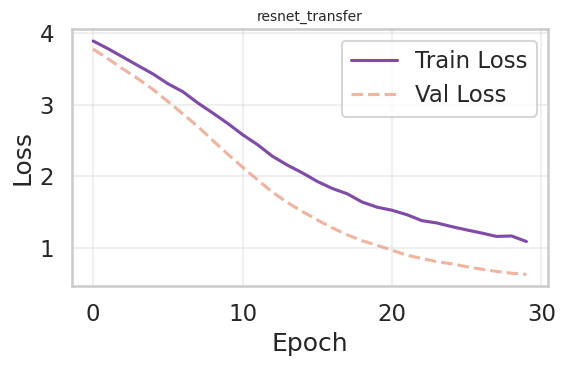

In [24]:

# same training hyperparameters of our network
transfer_config= {
    "experiment_name": "resnet_transfer",
    "batch_size": 64,
    "growth_rate": 32,
    "dropout": 0.2,
    "base_learning_rate": 0.001,
    "warmup_iter": 7500,
    "weight_decay": 0.001,
    "n_epochs": 30,
    "transform_stack_name": "default"
}

# Checkpoint: check if results already exist
result_csv_path = Path(SAVE_DIR) / f"{transfer_config['experiment_name']}.csv"
if result_csv_path.exists():
    print(f"Loading results from existing checkpoint: {result_csv_path}")
    result = pd.read_csv(result_csv_path)
else:
    result = run_experiment(transfer_config, net_transfer)
    df = pd.DataFrame(result)
    df.to_csv(result_csv_path)

print(f"\nFinal Results for {transfer_config['experiment_name']}:")
print(f"Best Validation Accuracy: {np.max(result['val_accuracy']):.4f}")
print(f"Test Accuracy: {np.max(result['test_accuracy']):.4f}")
plot_loss_curves(result)


Finetuning

In [25]:
sd = torch.load(Path(SAVE_DIR) / f"resnet_transfer.pt") 
net_transfer.load_state_dict(sd)

for layer in frozen_layers:
    set_requires_grad(layer, True)

summary(
    net_transfer,
    input_size=(1, 3, 224, 224)
)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [26]:
EPOCHS = 15

# reduce learning rate for fine-tuning
transfer_config= {
    "experiment_name": "resnet_tuning",
    "batch_size": 64,
    "growth_rate": 32,
    "dropout": 0.2,
    "base_learning_rate": 0.001*0.1,
    "warmup_iter": 7500,
    "weight_decay": 0.001,
    "n_epochs": EPOCHS,
    "transform_stack_name": "default"
}

# Checkpoint: check if results already exist
result_csv_path = Path(SAVE_DIR) / f"{transfer_config['experiment_name']}.csv"
if result_csv_path.exists():
    print(f"Loading results from existing checkpoint: {result_csv_path}")
    result = pd.read_csv(result_csv_path)
else:
    result = run_experiment(transfer_config, net_transfer)



Start running the model: resnet_tuning


Training resnet_tuning:   0%|          | 0/15 [00:00<?, ?it/s]

Training resnet_tuning:   0%|          | 0/15 [00:19<?, ?it/s, Train Loss=1.1061, Val Loss=0.6044, Val Acc=87.5136]

Training resnet_tuning:   7%|▋         | 1/15 [00:19<04:32, 19.48s/it, Train Loss=1.1061, Val Loss=0.6044, Val Acc=87.5136]

TEST


Training resnet_tuning:   7%|▋         | 1/15 [00:39<04:32, 19.48s/it, Train Loss=1.0473, Val Loss=0.5923, Val Acc=87.3501]

Training resnet_tuning:  13%|█▎        | 2/15 [00:39<04:16, 19.76s/it, Train Loss=1.0473, Val Loss=0.5923, Val Acc=87.3501]

Training resnet_tuning:  13%|█▎        | 2/15 [00:58<04:16, 19.76s/it, Train Loss=1.0251, Val Loss=0.5634, Val Acc=87.5136]

Training resnet_tuning:  20%|██        | 3/15 [00:58<03:50, 19.22s/it, Train Loss=1.0251, Val Loss=0.5634, Val Acc=87.5136]

Training resnet_tuning:  20%|██        | 3/15 [01:17<03:50, 19.22s/it, Train Loss=0.9823, Val Loss=0.5498, Val Acc=88.1134]

Training resnet_tuning:  27%|██▋       | 4/15 [01:17<03:31, 19.21s/it, Train Loss=0.9823, Val Loss=0.5498, Val Acc=88.1134]

TEST


Training resnet_tuning:  27%|██▋       | 4/15 [01:37<03:31, 19.21s/it, Train Loss=0.9619, Val Loss=0.5316, Val Acc=87.3501]

Training resnet_tuning:  33%|███▎      | 5/15 [01:37<03:15, 19.53s/it, Train Loss=0.9619, Val Loss=0.5316, Val Acc=87.3501]

Training resnet_tuning:  33%|███▎      | 5/15 [01:56<03:15, 19.53s/it, Train Loss=0.9166, Val Loss=0.5167, Val Acc=87.9498]

Training resnet_tuning:  40%|████      | 6/15 [01:56<02:54, 19.42s/it, Train Loss=0.9166, Val Loss=0.5167, Val Acc=87.9498]

Training resnet_tuning:  40%|████      | 6/15 [02:16<02:54, 19.42s/it, Train Loss=0.8945, Val Loss=0.4982, Val Acc=88.1134]

Training resnet_tuning:  47%|████▋     | 7/15 [02:16<02:35, 19.48s/it, Train Loss=0.8945, Val Loss=0.4982, Val Acc=88.1134]

Training resnet_tuning:  47%|████▋     | 7/15 [02:34<02:35, 19.48s/it, Train Loss=0.8588, Val Loss=0.4820, Val Acc=88.6041]

Training resnet_tuning:  53%|█████▎    | 8/15 [02:34<02:14, 19.27s/it, Train Loss=0.8588, Val Loss=0.4820, Val Acc=88.6041]

TEST


Training resnet_tuning:  53%|█████▎    | 8/15 [02:54<02:14, 19.27s/it, Train Loss=0.8295, Val Loss=0.4602, Val Acc=88.2770]

Training resnet_tuning:  60%|██████    | 9/15 [02:54<01:56, 19.40s/it, Train Loss=0.8295, Val Loss=0.4602, Val Acc=88.2770]

Training resnet_tuning:  60%|██████    | 9/15 [03:13<01:56, 19.40s/it, Train Loss=0.8112, Val Loss=0.4548, Val Acc=88.1679]

Training resnet_tuning:  67%|██████▋   | 10/15 [03:13<01:36, 19.32s/it, Train Loss=0.8112, Val Loss=0.4548, Val Acc=88.1679]

Training resnet_tuning:  67%|██████▋   | 10/15 [03:34<01:36, 19.32s/it, Train Loss=0.7914, Val Loss=0.4376, Val Acc=88.0589]

Training resnet_tuning:  73%|███████▎  | 11/15 [03:34<01:18, 19.68s/it, Train Loss=0.7914, Val Loss=0.4376, Val Acc=88.0589]

Training resnet_tuning:  73%|███████▎  | 11/15 [03:53<01:18, 19.68s/it, Train Loss=0.7412, Val Loss=0.4367, Val Acc=88.5496]

Training resnet_tuning:  80%|████████  | 12/15 [03:53<00:58, 19.49s/it, Train Loss=0.7412, Val Loss=0.4367, Val Acc=88.5496]

Training resnet_tuning:  80%|████████  | 12/15 [04:12<00:58, 19.49s/it, Train Loss=0.7403, Val Loss=0.4207, Val Acc=88.4406]

Training resnet_tuning:  87%|████████▋ | 13/15 [04:12<00:38, 19.34s/it, Train Loss=0.7403, Val Loss=0.4207, Val Acc=88.4406]

Training resnet_tuning:  87%|████████▋ | 13/15 [04:30<00:38, 19.34s/it, Train Loss=0.7022, Val Loss=0.4198, Val Acc=88.7132]

Training resnet_tuning:  93%|█████████▎| 14/15 [04:30<00:19, 19.10s/it, Train Loss=0.7022, Val Loss=0.4198, Val Acc=88.7132]

TEST


Training resnet_tuning:  93%|█████████▎| 14/15 [04:49<00:19, 19.10s/it, Train Loss=0.6776, Val Loss=0.4118, Val Acc=88.7132]

Training resnet_tuning: 100%|██████████| 15/15 [04:49<00:00, 18.84s/it, Train Loss=0.6776, Val Loss=0.4118, Val Acc=88.7132]

Training resnet_tuning: 100%|██████████| 15/15 [04:49<00:00, 19.27s/it, Train Loss=0.6776, Val Loss=0.4118, Val Acc=88.7132]

Done in  289.0928440093994  sec
Best accuracy  88.71319520174482



Final Results for resnet_tuning:
Best Validation Accuracy: 88.7132
Test Accuracy: 0.8971


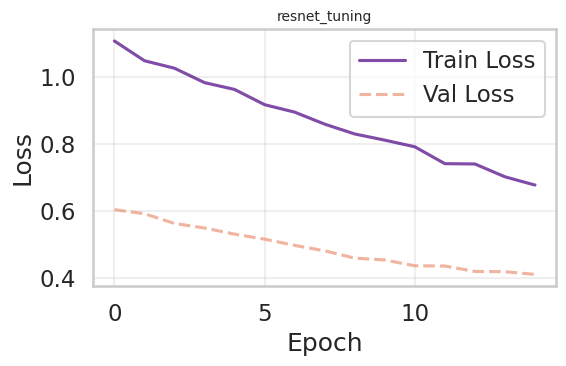

In [27]:
# Save results if not already saved
result_csv_path = Path(SAVE_DIR) / f"{transfer_config['experiment_name']}.csv"
if not result_csv_path.exists():
    df = pd.DataFrame(result)
    df.to_csv(result_csv_path)

print(f"\nFinal Results for {transfer_config['experiment_name']}:")
print(f"Best Validation Accuracy: {np.max(result['val_accuracy']):.4f}")
print(f"Test Accuracy: {np.max(result['test_accuracy']):.4f}")
plot_loss_curves(result)


### 2B.
Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [28]:

train_transform = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Create Dataset instances
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

# Create DataLoader instances
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [29]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                device: torch.device,
                scheduler: Optional[lr_scheduler.LRScheduler] = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions / total_samples
    return avg_loss, avg_acc.item()

def evaluate_model(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module,
                   device: torch.device) -> Tuple[float, float]:
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    avg_loss = epoch_loss / total_samples
    avg_acc = correct_predictions / total_samples
    return avg_loss, avg_acc.item()


def run_experiment(config: Dict, model = None):
    print("="*60 + f"\nStart running the model: {config['experiment_name']}\n" + "="*60)

    # Different learning rates
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if 'fc' in name:
            classifier_params.append(param)
        else:
            backbone_params.append(param)

    optimizer = optim.AdamW(
        [
            {'params': backbone_params, 'lr': config.get('backbone_lr', 1e-5)},
            {'params': classifier_params, 'lr': config.get('classifier_lr', 1e-3)}
        ],
        weight_decay=config.get('weight_decay', 0.01)
    )

    # SGDR Scheduler
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=config.get('t_0', 10),      # First cycle: 10 epochs
        T_mult=config.get('t_mult', 2),    # Next: 20, then 40 epochs
        eta_min=config.get('eta_min', 1e-6)
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=config.get('label_smoothing', 0.1))

    # Training Loop
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    # Use EPOCHS from the global scope, or pass it in config if it needs to be dynamic
    global EPOCHS # Access global EPOCHS
    pbar = tqdm(range(EPOCHS), desc=f"Training {config['experiment_name']}")
    for epoch in pbar:
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        scheduler.step()

        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), Path(SAVE_DIR) / f"{config['experiment_name']}.pt") #
        pbar.set_postfix({"Val Acc": f"{val_acc:.4f}", "Train Acc": f"{train_acc:.4f}"})

    # Final test and save result
    sd = torch.load(Path(SAVE_DIR) / f"{config['experiment_name']}.pt") #
    model.load_state_dict(sd)
    _, test_acc = evaluate_model(model, test_loader, criterion, device)
    print(f"Model '{config['experiment_name']}' completed. Test Accuracy: {test_acc:.4f}\n")

    result = config.copy()
    result.update({'test_accuracy': test_acc, 'best_val_accuracy': best_val_acc, 'history': history})
    return result

In [30]:
weights = ResNet18_Weights.IMAGENET1K_V1
net_transfer = get_model(NUM_CLASSES, weights).to(device)

# Freeze early layers of the network
frozen_layers = [
    net_transfer.conv1,
    net_transfer.bn1,
    net_transfer.layer1,
    net_transfer.layer2,
    net_transfer.layer3,
    net_transfer.layer4,
]

for layer in frozen_layers:
    set_requires_grad(layer, False)

In [31]:
EPOCHS = 30
config_2b = {
    "experiment_name": "resnet_transfer_2b",
    "backbone_lr": 1e-5,
    "classifier_lr": 1e-3,
    "weight_decay": 0.01,
    "t_0": 10,
    "t_mult": 2,
    "eta_min": 1e-6,
    "label_smoothing": 0.1
}

# Checkpoint: check if results already exist
result_csv_path = Path(SAVE_DIR) / f"{config_2b['experiment_name']}.csv"
if result_csv_path.exists():
    print(f"Loading results from existing checkpoint: {result_csv_path}")
    result = pd.read_csv(result_csv_path).to_dict('list')
    # Convert back to proper format for single values
    for key in result:
        if len(result[key]) == 1:
            result[key] = result[key][0]
else:
    result = run_experiment(config_2b, net_transfer)
    df = pd.DataFrame(result)
    df.to_csv(result_csv_path)

print(f"\nFinal Results for {config_2b['experiment_name']}:")
print(f"Best Validation Accuracy: {result.get('best_val_accuracy', 'N/A')}")
print(f"Test Accuracy: {result.get('test_accuracy', 'N/A')}")


Start running the model: resnet_transfer_2b


Training resnet_transfer_2b:   0%|          | 0/30 [00:00<?, ?it/s]

Training resnet_transfer_2b:   0%|          | 0/30 [00:12<?, ?it/s, Val Acc=0.6292, Train Acc=0.1971]

Training resnet_transfer_2b:   3%|▎         | 1/30 [00:12<05:54, 12.23s/it, Val Acc=0.6292, Train Acc=0.1971]

Training resnet_transfer_2b:   3%|▎         | 1/30 [00:24<05:54, 12.23s/it, Val Acc=0.7748, Train Acc=0.5176]

Training resnet_transfer_2b:   7%|▋         | 2/30 [00:24<05:39, 12.12s/it, Val Acc=0.7748, Train Acc=0.5176]

Training resnet_transfer_2b:   7%|▋         | 2/30 [00:36<05:39, 12.12s/it, Val Acc=0.8190, Train Acc=0.6233]

Training resnet_transfer_2b:  10%|█         | 3/30 [00:36<05:25, 12.05s/it, Val Acc=0.8190, Train Acc=0.6233]

Training resnet_transfer_2b:  10%|█         | 3/30 [00:48<05:25, 12.05s/it, Val Acc=0.8342, Train Acc=0.6566]

Training resnet_transfer_2b:  13%|█▎        | 4/30 [00:48<05:11, 11.97s/it, Val Acc=0.8342, Train Acc=0.6566]

Training resnet_transfer_2b:  13%|█▎        | 4/30 [00:59<05:11, 11.97s/it, Val Acc=0.8506, Train Acc=0.6683]

Training resnet_transfer_2b:  17%|█▋        | 5/30 [00:59<04:57, 11.91s/it, Val Acc=0.8506, Train Acc=0.6683]

Training resnet_transfer_2b:  17%|█▋        | 5/30 [01:12<04:57, 11.91s/it, Val Acc=0.8680, Train Acc=0.7051]

Training resnet_transfer_2b:  20%|██        | 6/30 [01:12<04:47, 12.00s/it, Val Acc=0.8680, Train Acc=0.7051]

Training resnet_transfer_2b:  20%|██        | 6/30 [01:23<04:47, 12.00s/it, Val Acc=0.8735, Train Acc=0.6988]

Training resnet_transfer_2b:  23%|██▎       | 7/30 [01:23<04:35, 11.98s/it, Val Acc=0.8735, Train Acc=0.6988]

Training resnet_transfer_2b:  23%|██▎       | 7/30 [01:35<04:35, 11.98s/it, Val Acc=0.8713, Train Acc=0.7114]

Training resnet_transfer_2b:  27%|██▋       | 8/30 [01:35<04:23, 11.97s/it, Val Acc=0.8713, Train Acc=0.7114]

Training resnet_transfer_2b:  27%|██▋       | 8/30 [01:47<04:23, 11.97s/it, Val Acc=0.8746, Train Acc=0.7084]

Training resnet_transfer_2b:  30%|███       | 9/30 [01:47<04:11, 11.98s/it, Val Acc=0.8746, Train Acc=0.7084]

Training resnet_transfer_2b:  30%|███       | 9/30 [02:00<04:11, 11.98s/it, Val Acc=0.8757, Train Acc=0.7130]

Training resnet_transfer_2b:  33%|███▎      | 10/30 [02:00<04:04, 12.21s/it, Val Acc=0.8757, Train Acc=0.7130]

Training resnet_transfer_2b:  33%|███▎      | 10/30 [02:13<04:04, 12.21s/it, Val Acc=0.8719, Train Acc=0.7100]

Training resnet_transfer_2b:  37%|███▋      | 11/30 [02:13<03:55, 12.41s/it, Val Acc=0.8719, Train Acc=0.7100]

Training resnet_transfer_2b:  37%|███▋      | 11/30 [02:26<03:55, 12.41s/it, Val Acc=0.8670, Train Acc=0.7114]

Training resnet_transfer_2b:  40%|████      | 12/30 [02:26<03:46, 12.56s/it, Val Acc=0.8670, Train Acc=0.7114]

Training resnet_transfer_2b:  40%|████      | 12/30 [02:40<03:46, 12.56s/it, Val Acc=0.8713, Train Acc=0.7190]

Training resnet_transfer_2b:  43%|████▎     | 13/30 [02:40<03:39, 12.90s/it, Val Acc=0.8713, Train Acc=0.7190]

Training resnet_transfer_2b:  43%|████▎     | 13/30 [02:54<03:39, 12.90s/it, Val Acc=0.8833, Train Acc=0.7302]

Training resnet_transfer_2b:  47%|████▋     | 14/30 [02:54<03:31, 13.21s/it, Val Acc=0.8833, Train Acc=0.7302]

Training resnet_transfer_2b:  47%|████▋     | 14/30 [03:07<03:31, 13.21s/it, Val Acc=0.8735, Train Acc=0.7291]

Training resnet_transfer_2b:  50%|█████     | 15/30 [03:07<03:17, 13.13s/it, Val Acc=0.8735, Train Acc=0.7291]

Training resnet_transfer_2b:  50%|█████     | 15/30 [03:20<03:17, 13.13s/it, Val Acc=0.8784, Train Acc=0.7261]

Training resnet_transfer_2b:  53%|█████▎    | 16/30 [03:20<03:05, 13.25s/it, Val Acc=0.8784, Train Acc=0.7261]

Training resnet_transfer_2b:  53%|█████▎    | 16/30 [03:34<03:05, 13.25s/it, Val Acc=0.8746, Train Acc=0.7261]

Training resnet_transfer_2b:  57%|█████▋    | 17/30 [03:34<02:55, 13.47s/it, Val Acc=0.8746, Train Acc=0.7261]

Training resnet_transfer_2b:  57%|█████▋    | 17/30 [03:47<02:55, 13.47s/it, Val Acc=0.8811, Train Acc=0.7370]

Training resnet_transfer_2b:  60%|██████    | 18/30 [03:47<02:41, 13.46s/it, Val Acc=0.8811, Train Acc=0.7370]

Training resnet_transfer_2b:  60%|██████    | 18/30 [04:01<02:41, 13.46s/it, Val Acc=0.8790, Train Acc=0.7386]

Training resnet_transfer_2b:  63%|██████▎   | 19/30 [04:01<02:27, 13.42s/it, Val Acc=0.8790, Train Acc=0.7386]

Training resnet_transfer_2b:  63%|██████▎   | 19/30 [04:15<02:27, 13.42s/it, Val Acc=0.8817, Train Acc=0.7454]

Training resnet_transfer_2b:  67%|██████▋   | 20/30 [04:15<02:15, 13.52s/it, Val Acc=0.8817, Train Acc=0.7454]

Training resnet_transfer_2b:  67%|██████▋   | 20/30 [04:28<02:15, 13.52s/it, Val Acc=0.8822, Train Acc=0.7413]

Training resnet_transfer_2b:  70%|███████   | 21/30 [04:28<02:01, 13.49s/it, Val Acc=0.8822, Train Acc=0.7413]

Training resnet_transfer_2b:  70%|███████   | 21/30 [04:41<02:01, 13.49s/it, Val Acc=0.8839, Train Acc=0.7544]

Training resnet_transfer_2b:  73%|███████▎  | 22/30 [04:41<01:47, 13.44s/it, Val Acc=0.8839, Train Acc=0.7544]

Training resnet_transfer_2b:  73%|███████▎  | 22/30 [04:55<01:47, 13.44s/it, Val Acc=0.8817, Train Acc=0.7471]

Training resnet_transfer_2b:  77%|███████▋  | 23/30 [04:55<01:33, 13.38s/it, Val Acc=0.8817, Train Acc=0.7471]

Training resnet_transfer_2b:  77%|███████▋  | 23/30 [05:08<01:33, 13.38s/it, Val Acc=0.8860, Train Acc=0.7531]

Training resnet_transfer_2b:  80%|████████  | 24/30 [05:08<01:20, 13.46s/it, Val Acc=0.8860, Train Acc=0.7531]

Training resnet_transfer_2b:  80%|████████  | 24/30 [05:22<01:20, 13.46s/it, Val Acc=0.8866, Train Acc=0.7411]

Training resnet_transfer_2b:  83%|████████▎ | 25/30 [05:22<01:07, 13.44s/it, Val Acc=0.8866, Train Acc=0.7411]

Training resnet_transfer_2b:  83%|████████▎ | 25/30 [05:35<01:07, 13.44s/it, Val Acc=0.8860, Train Acc=0.7522]

Training resnet_transfer_2b:  87%|████████▋ | 26/30 [05:35<00:54, 13.50s/it, Val Acc=0.8860, Train Acc=0.7522]

Training resnet_transfer_2b:  87%|████████▋ | 26/30 [05:48<00:54, 13.50s/it, Val Acc=0.8871, Train Acc=0.7517]

Training resnet_transfer_2b:  90%|█████████ | 27/30 [05:48<00:40, 13.44s/it, Val Acc=0.8871, Train Acc=0.7517]

Training resnet_transfer_2b:  90%|█████████ | 27/30 [06:02<00:40, 13.44s/it, Val Acc=0.8855, Train Acc=0.7642]

Training resnet_transfer_2b:  93%|█████████▎| 28/30 [06:02<00:26, 13.48s/it, Val Acc=0.8855, Train Acc=0.7642]

Training resnet_transfer_2b:  93%|█████████▎| 28/30 [06:15<00:26, 13.48s/it, Val Acc=0.8871, Train Acc=0.7463]

Training resnet_transfer_2b:  97%|█████████▋| 29/30 [06:15<00:13, 13.34s/it, Val Acc=0.8871, Train Acc=0.7463]

Training resnet_transfer_2b:  97%|█████████▋| 29/30 [06:29<00:13, 13.34s/it, Val Acc=0.8866, Train Acc=0.7514]

Training resnet_transfer_2b: 100%|██████████| 30/30 [06:29<00:00, 13.49s/it, Val Acc=0.8866, Train Acc=0.7514]

Training resnet_transfer_2b: 100%|██████████| 30/30 [06:29<00:00, 12.98s/it, Val Acc=0.8866, Train Acc=0.7514]

Model 'resnet_transfer_2b' completed. Test Accuracy: 0.8879


Final Results for resnet_transfer_2b:
Best Validation Accuracy: 0.887131929397583
Test Accuracy: 0.8878656625747681


finetune

In [32]:
sd = torch.load(Path(SAVE_DIR) / f"resnet_transfer_2b.pt") #
net_transfer.load_state_dict(sd)

for layer in frozen_layers:
    set_requires_grad(layer, True)


In [33]:
EPOCHS = 15

transfer_config= {
    "experiment_name": "resnet_tuning_2b",
    "backbone_lr": 1e-6, # Further reduce LR for fine-tuning
    "classifier_lr": 1e-4, # Further reduce LR for fine-tuning
    "weight_decay": 0.01,
    "t_0": 5, # Shorter cycle for fine-tuning
    "t_mult": 2,
    "eta_min": 1e-7,
    "label_smoothing": 0.05 # Slightly less smoothing for fine-tuning
}

# Checkpoint: check if results already exist
result_csv_path = Path(SAVE_DIR) / f"{transfer_config['experiment_name']}.csv"
if result_csv_path.exists():
    print(f"Loading results from existing checkpoint: {result_csv_path}")
    result = pd.read_csv(result_csv_path).to_dict('list')
    # Convert back to proper format for single values
    for key in result:
        if len(result[key]) == 1:
            result[key] = result[key][0]
else:
    result = run_experiment(transfer_config, net_transfer)
    df = pd.DataFrame(result)
    df.to_csv(result_csv_path)

print(f"\nFinal Results for {transfer_config['experiment_name']}:")
print(f"Best Validation Accuracy: {result.get('best_val_accuracy', 'N/A')}")
print(f"Test Accuracy: {result.get('test_accuracy', 'N/A')}")


Start running the model: resnet_tuning_2b


Training resnet_tuning_2b:   0%|          | 0/15 [00:00<?, ?it/s]

Training resnet_tuning_2b:   0%|          | 0/15 [00:13<?, ?it/s, Val Acc=0.8871, Train Acc=0.7626]

Training resnet_tuning_2b:   7%|▋         | 1/15 [00:13<03:13, 13.84s/it, Val Acc=0.8871, Train Acc=0.7626]

Training resnet_tuning_2b:   7%|▋         | 1/15 [00:28<03:13, 13.84s/it, Val Acc=0.8920, Train Acc=0.7493]

Training resnet_tuning_2b:  13%|█▎        | 2/15 [00:28<03:04, 14.21s/it, Val Acc=0.8920, Train Acc=0.7493]

Training resnet_tuning_2b:  13%|█▎        | 2/15 [00:42<03:04, 14.21s/it, Val Acc=0.8888, Train Acc=0.7533]

Training resnet_tuning_2b:  20%|██        | 3/15 [00:42<02:47, 13.99s/it, Val Acc=0.8888, Train Acc=0.7533]

Training resnet_tuning_2b:  20%|██        | 3/15 [00:55<02:47, 13.99s/it, Val Acc=0.8920, Train Acc=0.7479]

Training resnet_tuning_2b:  27%|██▋       | 4/15 [00:55<02:32, 13.91s/it, Val Acc=0.8920, Train Acc=0.7479]

Training resnet_tuning_2b:  27%|██▋       | 4/15 [01:08<02:32, 13.91s/it, Val Acc=0.8904, Train Acc=0.7542]

Training resnet_tuning_2b:  33%|███▎      | 5/15 [01:08<02:15, 13.53s/it, Val Acc=0.8904, Train Acc=0.7542]

Training resnet_tuning_2b:  33%|███▎      | 5/15 [01:21<02:15, 13.53s/it, Val Acc=0.8915, Train Acc=0.7580]

Training resnet_tuning_2b:  40%|████      | 6/15 [01:21<02:00, 13.39s/it, Val Acc=0.8915, Train Acc=0.7580]

Training resnet_tuning_2b:  40%|████      | 6/15 [01:35<02:00, 13.39s/it, Val Acc=0.8893, Train Acc=0.7542]

Training resnet_tuning_2b:  47%|████▋     | 7/15 [01:35<01:48, 13.55s/it, Val Acc=0.8893, Train Acc=0.7542]

Training resnet_tuning_2b:  47%|████▋     | 7/15 [01:49<01:48, 13.55s/it, Val Acc=0.8904, Train Acc=0.7582]

Training resnet_tuning_2b:  53%|█████▎    | 8/15 [01:49<01:35, 13.58s/it, Val Acc=0.8904, Train Acc=0.7582]

Training resnet_tuning_2b:  53%|█████▎    | 8/15 [02:03<01:35, 13.58s/it, Val Acc=0.8915, Train Acc=0.7533]

Training resnet_tuning_2b:  60%|██████    | 9/15 [02:03<01:21, 13.62s/it, Val Acc=0.8915, Train Acc=0.7533]

Training resnet_tuning_2b:  60%|██████    | 9/15 [02:16<01:21, 13.62s/it, Val Acc=0.8926, Train Acc=0.7525]

Training resnet_tuning_2b:  67%|██████▋   | 10/15 [02:16<01:07, 13.43s/it, Val Acc=0.8926, Train Acc=0.7525]

Training resnet_tuning_2b:  67%|██████▋   | 10/15 [02:29<01:07, 13.43s/it, Val Acc=0.8942, Train Acc=0.7383]

Training resnet_tuning_2b:  73%|███████▎  | 11/15 [02:29<00:53, 13.35s/it, Val Acc=0.8942, Train Acc=0.7383]

Training resnet_tuning_2b:  73%|███████▎  | 11/15 [02:41<00:53, 13.35s/it, Val Acc=0.8942, Train Acc=0.7607]

Training resnet_tuning_2b:  80%|████████  | 12/15 [02:41<00:39, 13.06s/it, Val Acc=0.8942, Train Acc=0.7607]

Training resnet_tuning_2b:  80%|████████  | 12/15 [02:53<00:39, 13.06s/it, Val Acc=0.8931, Train Acc=0.7681]

Training resnet_tuning_2b:  87%|████████▋ | 13/15 [02:53<00:25, 12.71s/it, Val Acc=0.8931, Train Acc=0.7681]

Training resnet_tuning_2b:  87%|████████▋ | 13/15 [03:05<00:25, 12.71s/it, Val Acc=0.8926, Train Acc=0.7503]

Training resnet_tuning_2b:  93%|█████████▎| 14/15 [03:05<00:12, 12.57s/it, Val Acc=0.8926, Train Acc=0.7503]

Training resnet_tuning_2b:  93%|█████████▎| 14/15 [03:18<00:12, 12.57s/it, Val Acc=0.8937, Train Acc=0.7607]

Training resnet_tuning_2b: 100%|██████████| 15/15 [03:18<00:00, 12.52s/it, Val Acc=0.8937, Train Acc=0.7607]

Training resnet_tuning_2b: 100%|██████████| 15/15 [03:18<00:00, 13.21s/it, Val Acc=0.8937, Train Acc=0.7607]

Model 'resnet_tuning_2b' completed. Test Accuracy: 0.8906


Final Results for resnet_tuning_2b:
Best Validation Accuracy: 0.894220232963562
Test Accuracy: 0.8905742168426514
